# SABR Market Model Example

In [9]:
import sys
import os
# add the directory
sys.path.append(os.path.abspath("../Files"))

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.special import ndtr
import matplotlib.pyplot as plt

# import own module
import fixed_income_derivatives_E2024 as fid

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def fit_sabr_obj(param,sigma_market,K,T,R):
    sigma_0, beta, upsilon, rho = param
    N = len(sigma_market)
    y = 0
    for n in range(0,N):
        sigma_sabr = fid.sigma_sabr(K[n],T,R,sigma_0,beta,upsilon,rho,type = "call")
        y += (sigma_market[n]-sigma_sabr)**2
    return y

In [11]:
def vector_to_bins(v,mini,maxi,N):
    v = np.sort(v,kind="heapsort")
    mesh = (maxi-mini)/N
    lb, ub = np.array([mini+i*mesh for i in range(0,N)]), np.array([mini+i*mesh for i in range(1,N+1)])
    y = np.zeros([N])
    i, j, count = 0, 0, 0
    while i < N:
        if v[j] < lb[i]:
            # print(f"A, i: {i}, lb: {lb[i]}, ub: {ub[i]}, j: {j}, v: {v[j]},count: {count}, y: {y}")
            j += 1
        if lb[i] <= v[j] <= ub[i]:
            count += 1
            # print(f"B, i: {i}, lb: {lb[i]}, ub: {ub[i]}, j: {j}, v: {v[j]},count: {count}, y: {y}")
            j += 1
        elif ub[i] < v[j]:
            y[i] = count
            count = 0
            # print(f"C, i: {i}, lb: {lb[i]}, ub: {ub[i]}, j: {j}, v: {v[j]},count: {count}, y: {y}")
            i += 1
        if j > len(v) - 0.5:
            y[i] = count
            i = N
        # print(f"    after", i,lb[i],ub[i],j,v[j],count,y)
    return y, lb, ub

## Problem 1

In [12]:
alpha = 0.5
T_max = 7
idx_exer, idx_mat = 4, 14
K_swaption_offset = [-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300]
N_swaption = len(K_swaption_offset)
M = int(round(T_max/alpha)+1)
T = np.array([i*alpha for i in range(0,M)])
p = np.array([1, 0.98429046, 0.96633686, 0.94690318, 0.92655036, 0.90568659, 0.88460647, 0.86352084, 0.84257919, 0.82188628, 0.80151436, 0.78151217, 0.76191149, 0.74273188, 0.72398415])
price_market = np.array([0.12301549, 0.10339456, 0.08421278, 0.06567338, 0.04843543, 0.03300976, 0.02048677, 0.01173834, 0.00648577, 0.00361682, 0.00215934, 0.00137503, 0.00093634])

### Problem 1

In [13]:
# Problem 1
S_swap = 0
for i in range(idx_exer+1,idx_mat + 1):
    S_swap += alpha*p[i]
R_swap = (p[idx_exer] - p[idx_mat])/S_swap
print(f"accrual factor: {S_swap}, 2Y5Y par swap rate: {R_swap}")
K, iv_market = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    K[i] = R_swap + K_swaption_offset[i]/10000
    iv_market[i] = fid.black_swaption_iv(price_market[i],T[idx_exer],K[i],S_swap,R_swap,type = "call", iv0 = 0.25, max_iter = 1000, prec = 1.0e-12)
print(iv_market)

accrual factor: 4.06496671, 2Y5Y par swap rate: 0.04983219407472096
[0.37271288 0.32282708 0.28265711 0.24785851 0.22072556 0.19726113
 0.17974193 0.16969789 0.16614408 0.16689728 0.17143419 0.17752206
 0.18457536]


### Problem 2

In [14]:
# Problem 2
param_0 = 0.055, 0.5, 0.48,-0.25
result = minimize(fid.fit_sabr_obj,param_0,method = 'nelder-mead',args = (iv_market,K,T[idx_exer],R_swap),options={'xatol': 1e-8,'disp': True})
print(f"Parameters from fit: {result.x}, squared dev: {result.fun}")
sigma_0, beta, upsilon, rho = result.x
iv_fit, price_fit = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    iv_fit[i] = fid.sigma_sabr(K[i],T[idx_exer],R_swap,sigma_0,beta,upsilon,rho,type = "call")
    price_fit[i] = fid.black_swaption_price(iv_fit[i],T[idx_exer],K[i],S_swap,R_swap,type = "call")
print(f"Parameters from the fit: sigma_0: {sigma_0}, beta: {beta}, upsilon: {upsilon}, rho: {rho}")
print(f"Implied volatilities from market prices:")
print(iv_fit)

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 272
         Function evaluations: 467
Parameters from fit: [ 0.0379421   0.49411123  0.57359064 -0.32175924], squared dev: 2.0978386442282128e-06
Parameters from the fit: sigma_0: 0.03794210468649329, beta: 0.4941112287951783, upsilon: 0.5735906395611122, rho: -0.321759239869148
Implied volatilities from market prices:
[0.37247181 0.32300549 0.28259141 0.24870706 0.22021729 0.196992
 0.179755   0.16947376 0.16597348 0.16746727 0.17183954 0.17761341
 0.1839624 ]


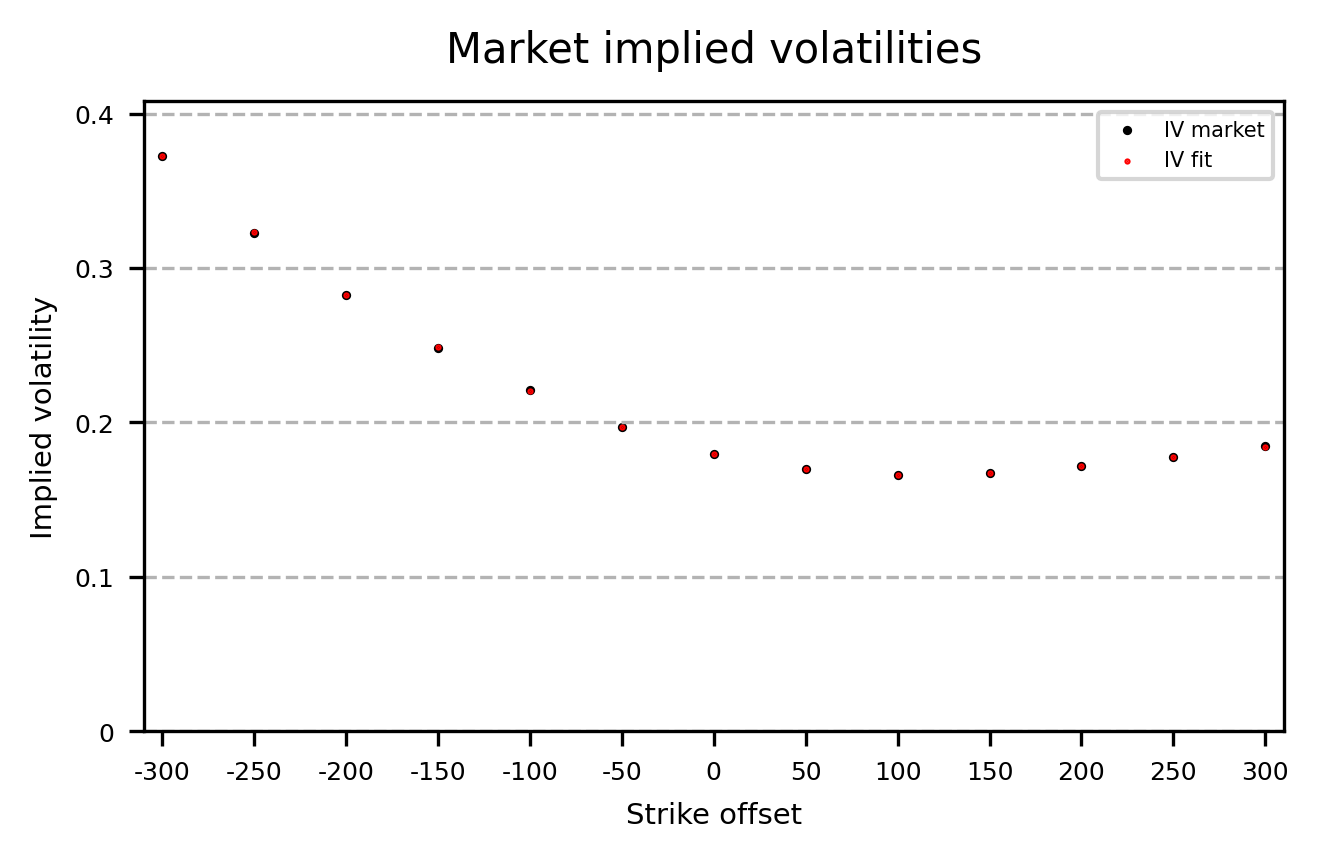

In [15]:
# Plot of market implied volatilities
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Market implied volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-10,xticks[-1]+10])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels([0,0.1,0.2,0.3,0.4],fontsize = 6)
ax.set_ylim([0,0.408])
ax.set_ylabel(f"Implied volatility",fontsize = 7)
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(K_swaption_offset, iv_market, s = 6, color = 'black', marker = ".",label="IV market")
p2 = ax.scatter(K_swaption_offset, iv_fit, s = 1, color = 'red', marker = ".",label="IV fit")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# fig.savefig("C:/.pdf")
plt.show()

### Problem 3

In [16]:
# Problem 3 -  Simulating the SABR model
seed = 2024
# np.random.seed(4)  # Plot that looks realistic
# np.random.seed(13)  # Volatility blows up
# np.random.seed(3)  # Volatility goes to 0 14 maybe
np.random.seed(seed)
T_simul, M_simul = 2, 4000
F_simul, sigma_simul = fid.sabr_simul(R_swap,sigma_0,beta,upsilon,rho,M_simul,T_simul)
t_simul = np.array([i*T_simul/M_simul for i in range(0,M_simul+1)])

### Problem 4

In [17]:
# Problem 4 - Pricing a digital option
M_simul, T_digital = 2000, 2
N_simul = 1000
strike = R_swap + 75/10000
F_simul_digital, sigma_simul_digital = np.zeros([M_simul]), np.zeros([M_simul])
frac_ITM = np.zeros([N_simul])
count = 0
for n in range(0,N_simul):
    F_simul_digital, sigma_simul_digital = fid.sabr_simul(R_swap, sigma_0, beta, upsilon, rho, M_simul, T_digital)
    if F_simul_digital[-1] > strike:
        count += 1
    frac_ITM[n] = count/(n+1)
print(f"frac ITM: {frac_ITM[-1]}, price = {p[4]*frac_ITM[-1]}")
idx_conv_check = np.array([i*int(N_simul/10) - 1 for i in range(1,11)])
for idx in idx_conv_check:
    print(f"idx: {idx},frac_ITM: {frac_ITM[idx]}")

/Users/johan/Library/CloudStorage/GoogleDrive-johan.oelgaard@gmail.com/My Drive/04 Økonomi/09 Fixed Income/02 Git/FixedIncome/Files/fixed_income_derivatives_E2024.py:1140: RuntimeWarning: invalid value encountered in scalar power
  F[m] = F[m-1] + sigma[m-1]*F[m-1]**beta*delta_sqrt*Z[0,m-1]


frac ITM: 0.265, price = 0.2455358454
idx: 99,frac_ITM: 0.38
idx: 199,frac_ITM: 0.295
idx: 299,frac_ITM: 0.2733333333333333
idx: 399,frac_ITM: 0.2625
idx: 499,frac_ITM: 0.256
idx: 599,frac_ITM: 0.2683333333333333
idx: 699,frac_ITM: 0.2671428571428571
idx: 799,frac_ITM: 0.27
idx: 899,frac_ITM: 0.2633333333333333
idx: 999,frac_ITM: 0.265


### Problem 5

In [18]:
# Problem 5 -  Hedging in the SABR model
idx_position = 9
# Bumping sigma_0
sigma_0_bump = sigma_0 - 0.001
iv_sigma_0 = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap,sigma_0_bump,beta,upsilon,rho,type = "call")
price_sigma_0 = fid.black_swaption_price(iv_sigma_0,T[idx_exer],K[idx_position],S_swap,R_swap,type = "call")
print(f"price after bumping sigma_0: {price_sigma_0}, diff: {price_sigma_0-price_market[idx_position]}")
# Bumping the entire spot rate curve
R = fid.spot_rates_from_zcb_prices(T,p)
R_bump = R - 0.0001*np.ones([M])
p_bump = fid.zcb_prices_from_spot_rates(T,R_bump)
S_bump = 0
for i in range(idx_exer+1,idx_mat + 1):
    S_bump += alpha*p_bump[i]
R_swap_bump = (p_bump[idx_exer] - p_bump[idx_mat])/S_bump
sigma_delta = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap_bump,sigma_0,beta,upsilon,rho,type = "call")
price_delta = fid.black_swaption_price(sigma_delta,T[idx_exer],K[idx_position],S_bump,R_swap_bump,type = "call")
print(f"price after bumping spot rates: {price_delta}, diff: {price_delta-price_market[idx_position]} in percent :{(price_delta-price_market[idx_position])/price_market[idx_position]}")

price after bumping sigma_0: 0.0033917683612518317, diff: -0.0002250516387481685
price after bumping spot rates: 0.003608516695797702, diff: -8.303304202298203e-06 in percent :-0.0022957471486826004


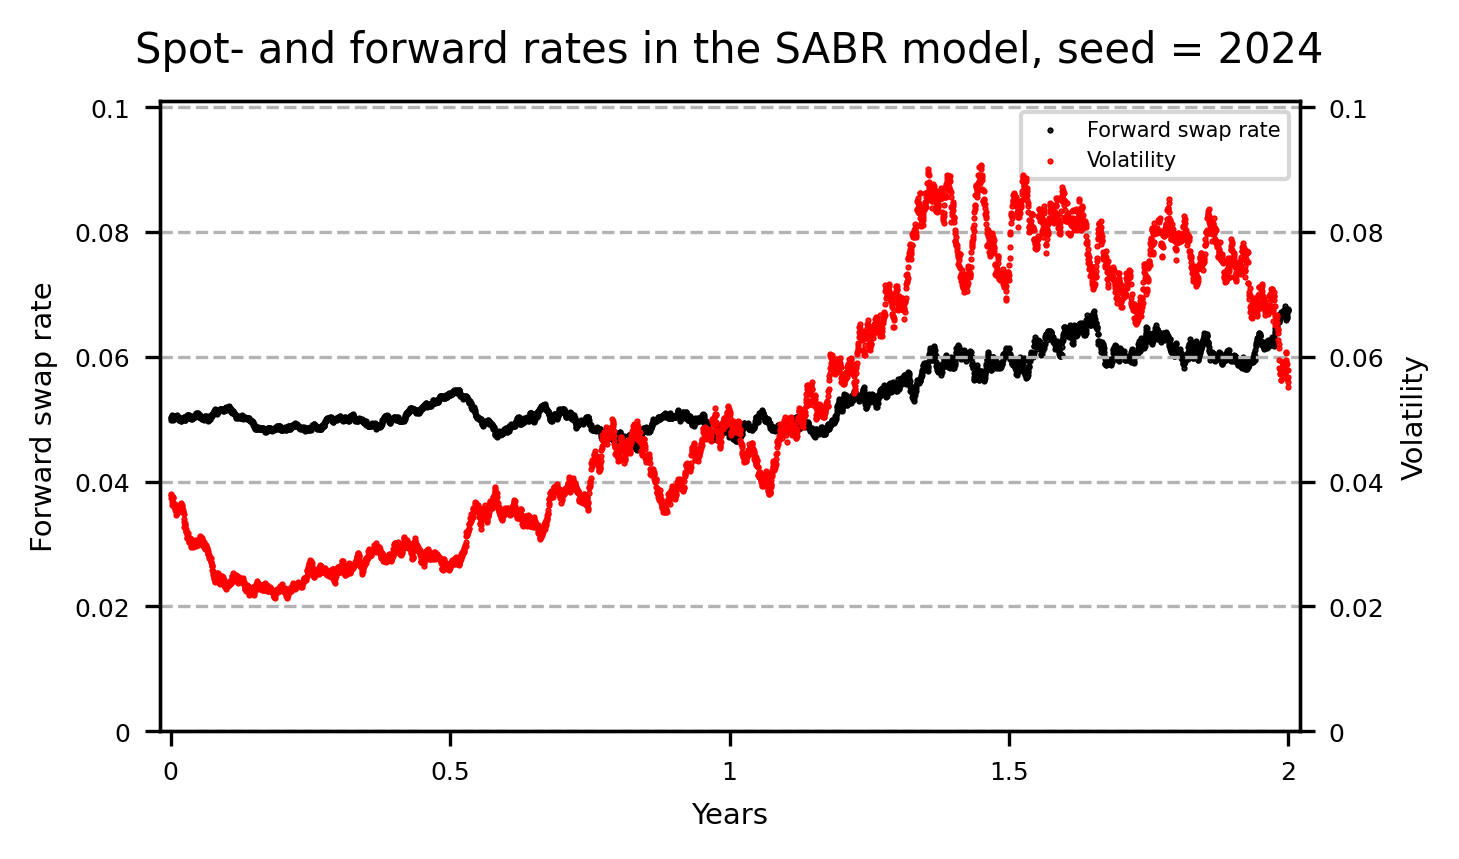

In [19]:
# PLot of simulated values in the SABR model
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Spot- and forward rates in the SABR model, seed = {seed}", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,0.5,1,1.5,2]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.02,xticks[-1]+0.02])
plt.xlabel(f"Years",fontsize = 7)
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax.set_ylim([0,0.101])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
# plt.minorticks_on()
# plt.grid(which='minor', color='grey', linestyle='--')
ax.set_ylabel(f"Forward swap rate",fontsize = 7)
p1 = ax.scatter(t_simul, F_simul, s = 1, color = 'black', marker = ".",label="Forward swap rate")
ax2 = ax.twinx()
ax2.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax2.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax2.set_ylim([0,0.101])
ax2.set_ylabel(f"Volatility",fontsize = 7)
p2 = ax2.scatter(t_simul, sigma_simul, s = 1, color = 'red', marker = ".",label="Volatility")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# fig.savefig("C:/.pdf")
plt.show()